In [1]:
# Reading the indicators data which was saved as csv file in notebook2
Indicators_data<- read.csv('C:/Users/hrith/OneDrive/Documents/RESUME_PROJECTS_COPY/SSGA_internship_assignment/Assignment_1/Indicators_data.csv')
Indicators_data$date <- as.Date(Indicators_data$date)

In [2]:
# Importing necessary libraries
library(dplyr)
library(ggplot2)
library(zoo)
library(lubridate)
library(xts)
library(PerformanceAnalytics)
library(quantmod)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Attaching package: 'lubridate'

The following object is masked from 'package:base':

    date

Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 

Attaching package: 'xts'

The following objects are masked from 'package:dplyr':

    first, last

Warning message:
"package 'PerformanceAnalytics' was built under R version 3.6.3"
Attaching package: 'PerformanceAnalytics'

The following object is masked from 'package:graphics':

    legend

Loading required package: TTR
Registered S3 method overwritten by 'quantmod':
  m

#Strategy_a : Will check the yearly change of each indicator (except for NAI, we will directly check its value) in the current month and invest in the next month if atleast 3 of them are in the support of investing (majority).

In [3]:
# making a separate dataframe of indicators which are required for implementing this strategy

In [4]:
# indicator_1 -> NAI

# indicator_2a -> monthly change in yearly inflation
# indicator_2b -> (6m_ma - 24m_ma) of yearly inflation

# indicator_3a -> yearly difference of US dolar index in current month
# indicator_3b -> (3m_ma - 12m_ma) of US dolar index

# indicator_4a -> yearly difference of t_bills_2Y_yield in current month
# indicator_4b -> (6m_ma - 24m_ma) of t_bills_2Y_yield

# indicator_5a -> yearly difference of credit_spread_monthly in current month
# indicator_5b -> (3m_ma - 12m_ma) of credit_spread_monthly

In [5]:
selected_columns <- Indicators_data[, c("date" , "indicator_1", "indicator_2a", "indicator_3a" , "indicator_4a" , "indicator_5a" )]
Indicators_data_selected_a <- data.frame(selected_columns)

In [6]:
cat(" initial rows of selected indicators for this strategy :", "\n")
head(Indicators_data_selected_a)

 initial rows of selected indicators for this strategy : 


date,indicator_1,indicator_2a,indicator_3a,indicator_4a,indicator_5a
2007-02-01,-0.48,-0.44821261,-2.1662,0.48,-0.7853557
2007-03-01,0.19,0.34449560,-2.7348,0.18,-0.7145000
2007-04-01,0.23,0.37793651,-3.4163,-0.16,-0.3917391
2007-05-01,-0.11,-0.20527253,-4.1113,-0.22,-0.3180952
2007-06-01,0.03,0.11696098,-2.7893,-0.20,-0.4526087
2007-07-01,-0.05,-0.01712063,-4.2478,-0.14,-0.6681818


In [7]:
# Since we are only using the signs of indicators for our decision (and not the magnitude, which also a drawback of these 
# strategies), it would be convenient if we flipped the sign of indicators such that we can make the following statement:
# invest in the next month if atleast 3 indicators have positive sign in current month.

# This is implemented below:

Indicators_data_selected_a$indicator_2a <- -Indicators_data_selected_a$indicator_2a
Indicators_data_selected_a$indicator_3a <- -Indicators_data_selected_a$indicator_3a
Indicators_data_selected_a$indicator_4a <- -Indicators_data_selected_a$indicator_4a
Indicators_data_selected_a$indicator_5a <- -Indicators_data_selected_a$indicator_5a

In [8]:
# Defining the minimum number of positive indicators required to invest
min_positive_indicators = 3

# Calculating the binary vector for investment decisions (0 means don't invest and 1 means invest)

investment_strategy_a <- Indicators_data_selected_a %>%
  mutate(positive_indicators = rowSums(select(., starts_with("indicator")) > 0)) %>%
  mutate(invest = ifelse(positive_indicators >= min_positive_indicators, 1, 0)) %>%
  pull(invest)

# Inserting 0 in the front, so that length is same as the return vector and it means that we are not investing in 2007/01/01
# which is becauce we have indicators data from 2007/01/01, hence we can only start investing from 2007/02/01
investment_strategy_a <- c(0, investment_strategy_a)

# Printing the binary vector
cat("monthly investment decisions of this strategy :", "\n")
print(investment_strategy_a)

monthly investment decisions of this strategy : 
  [1] 0 1 1 1 1 1 1 1 1 0 0 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 [38] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 1 1 1
 [75] 1 1 1 1 0 0 1 1 0 0 0 0 1 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[112] 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 1 1 1 0 1 1 1 0 0 0 1 0 0 0 0 0 0 0
[149] 0 1 1 0 1 0 0 0 1 0 1 0 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0
[186] 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1


In [9]:
#making s&p 500 dataframe which has monthly values from 2007-01-01 to 2023-08-01 , will use this to calculate monthly returns
sp_500_a <- read.csv('C:/Users/hrith/OneDrive/Documents/RESUME_PROJECTS_COPY/SSGA_internship_assignment/Assignment_1/s&p_500_a.csv')

cat(" initial rows of sp_500_a :", "\n")
head(sp_500_a)

 initial rows of sp_500_a : 


Date,Open,High,Low,Close,Adj.Close,Volume
2007-01-01,1418.03,1441.61,1403.97,1438.24,1438.24,56686200000
2007-02-01,1437.90,1461.57,1389.42,1406.82,1406.82,51844990000
2007-03-01,1406.80,1438.89,1363.98,1420.86,1420.86,67622250000
2007-04-01,1420.83,1498.02,1416.37,1482.37,1482.37,57032470000
2007-05-01,1482.37,1535.56,1476.70,1530.62,1530.62,64958050000
2007-06-01,1530.62,1540.56,1484.18,1503.35,1503.35,65322800000


In [10]:
# calculating monthly returns of strategy_a
strategy_returns_a <- investment_strategy_a * c(0, diff(sp_500_a$Open)) / lag(sp_500_a$Open)

# Converting the date column to a Date format
sp_500_a$Date <- as.Date(sp_500_a$Date)

# Creating an xts time series object
strategy_returns_a <- xts(strategy_returns_a, order.by = sp_500_a$Date)

#printing the monthly returns
cat("monthly returs of this strategy :", "\n")
strategy_returns_a

monthly returs of this strategy : 


                    [,1]
2007-01-01            NA
2007-02-01  0.0140123937
2007-03-01 -0.0216287468
2007-04-01  0.0099729220
2007-05-01  0.0433127404
2007-06-01  0.0325492287
2007-07-01 -0.0169604219
2007-08-01 -0.0328844917
2007-09-01  0.0129055557
2007-10-01  0.0000000000
2007-11-01  0.0000000000
2007-12-01  0.0000000000
2008-01-01 -0.0078803715
2008-02-01  0.0000000000
2008-03-01 -0.0349267556
2008-04-01 -0.0030365043
2008-05-01  0.0449031106
2008-06-01  0.0000000000
2008-07-01  0.0000000000
2008-08-01  0.0000000000
2008-09-01  0.0145026165
2008-10-01 -0.0960219255
2008-11-01  0.0000000000
2008-12-01  0.0000000000
2009-01-01  0.0000000000
2009-02-01  0.0000000000
2009-03-01  0.0000000000
2009-04-01  0.0000000000
2009-05-01  0.0000000000
2009-06-01  0.0000000000
2009-07-01  0.0000000000
2009-08-01  0.0753675668
2009-09-01  0.0000000000
2009-10-01  0.0000000000
2009-11-01 -0.0177550501
2009-12-01  0.0605203321
2010-01-01  0.0000000000
2010-02-01 -0.0382156281
2010-03-01  0.0293046497


In [11]:
# Creating a function to calculate performance parameters:

calculate_performance_parameters <- function(strategy_returns, risk_free_rate) {
  
  # Max drawdown
  temp1 <- na.omit(strategy_returns)   #omitting NA to avoid bias in the calculation of Annualized returns
  cumulative_returns <- cumprod(1 + temp1)
  max_cumulative_returns <- cummax(cumulative_returns)  
  drawdown <- cumulative_returns - max_cumulative_returns
  max_drawdown <- -min(drawdown)
    
    
  # Annualized returns
  cumulative_return <- prod(1 + temp1)
  total_trading_days <- length(temp1)
  trading_years <- total_trading_days / 12
  annualized_return <- ((cumulative_return ^ (1 / trading_years)) - 1) * 100
  
  # Annualized risk
  temp2 <- na.omit(strategy_returns)
  annualized_risk <- sd(temp2) * sqrt(12)
  
  # Sharpe ratio
  sharpe_ratio <- (annualized_return-risk_free_rate) / (annualized_risk*100)
  
  # Creating a list to store the results
  performance_parameters <- list(
    Max_Drawdown = max_drawdown,
    Cumulative_Return = cumulative_return * 100,
    Annualized_Return = annualized_return,
    Annualized_Risk = annualized_risk,
    Sharpe_Ratio = sharpe_ratio
  )
  
  return(performance_parameters)
}

In [12]:
#calculating the performance parameters
risk_free_rate <- 0    #as per the assumptions of assignment
performance_params_a <- calculate_performance_parameters(strategy_returns_a,risk_free_rate)

# Printing the results
cat("performance parameters of strategy_a :", "\n")
print(performance_params_a)

performance parameters of strategy_a : 
$Max_Drawdown
[1] 0.1941106

$Cumulative_Return
[1] 278.0109

$Annualized_Return
[1] 6.359821

$Annualized_Risk
[1] 0.09526185

$Sharpe_Ratio
[1] 0.6676147



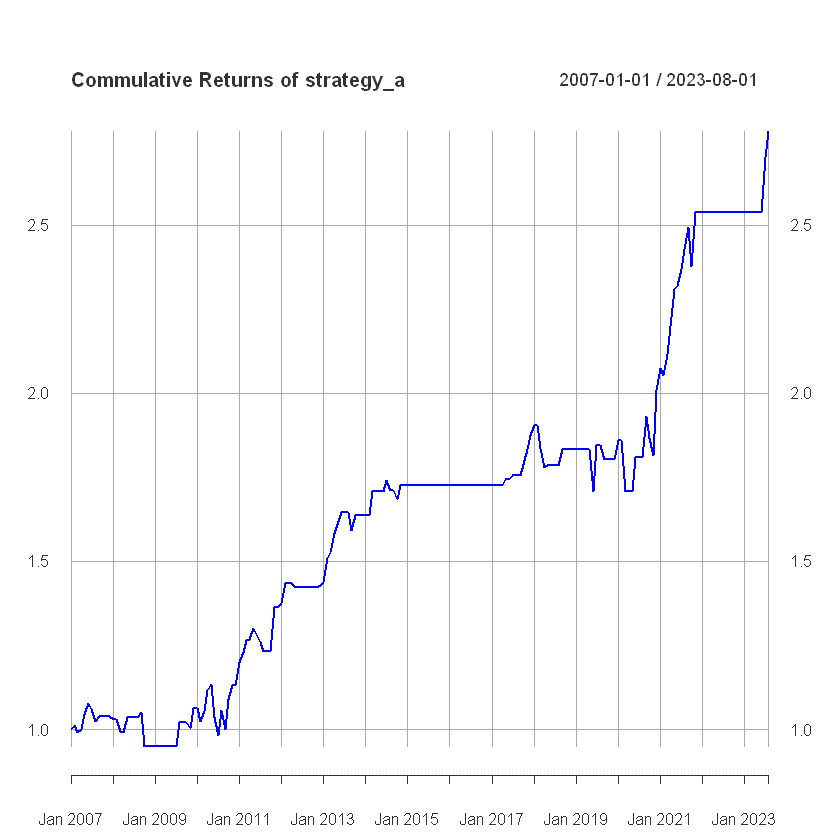

[1] -0.1941106

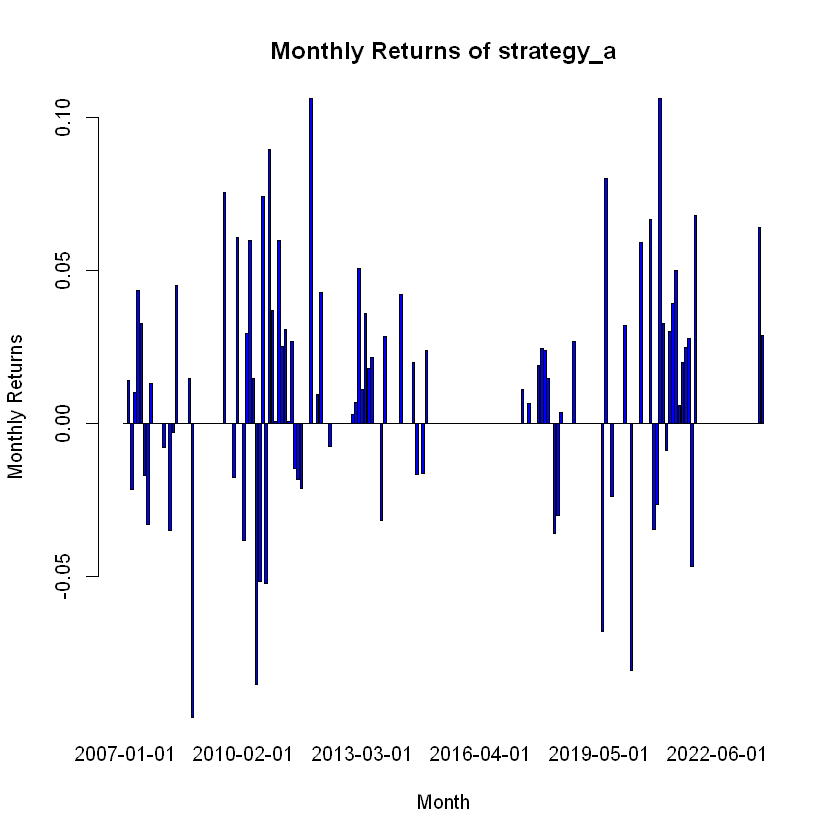

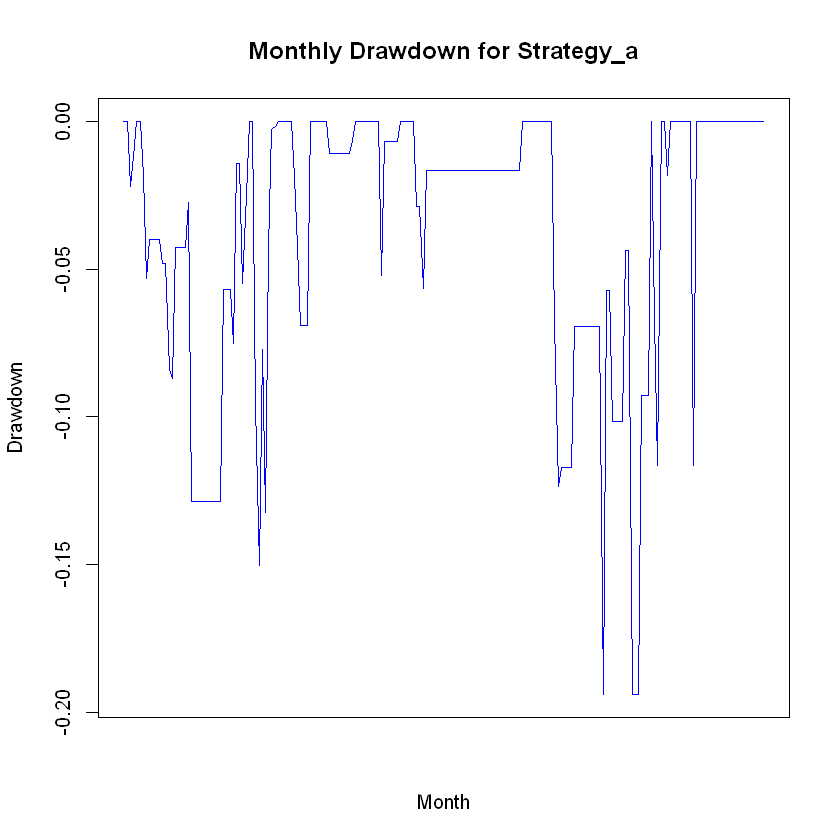

In [13]:
# plotting the commulative returns, monthly returns and drawdowns for strategy_a

strategy_returns_a[is.na(strategy_returns_a)] <- 0    #replacing initial NA by 0 to avoid plotting errors

#1.commulative returns
cumulative_returns_aa <- cumprod(1 + strategy_returns_a)
plot(cumulative_returns_aa, type = "l", col = "blue", xlab = "Date", ylab = "Value", main = "Commulative Returns of strategy_a")

#2.monthly returns
barplot(strategy_returns_a, col = "blue", 
        xlab = "Month", ylab = "Monthly Returns", 
        main = "Monthly Returns of strategy_a")

#3. Calculating maximum cumulative returns up to each month
max_cumulative_returns_aa <- cummax(cumulative_returns_aa)

# Calculating drawdown as the difference between cumulative returns and max cumulative returns
drawdown_aa <- cumulative_returns_aa - max_cumulative_returns_aa
max_drawdown_aa <- min(drawdown_aa)
max_drawdown_aa

# Creating a sequence of months for plotting
months <- seq(from = 1, to = length(drawdown_aa), by = 1)

# Plotting the drawdown for strategy_a
plot(months, drawdown_aa, type = "l", col = "blue",
     xlab = "Month", ylab = "Drawdown",
     main = "Monthly Drawdown for Strategy_a", xaxt = "n")

#Strategy_b : will check the difference between moving avg of two windows of each indicator (except for NAI, we will directly check its value)in the current month and invest in the next month if atleast 3 of them supports the investing decision (majority)

In [14]:
# making a separate dataframe of indicators which are required for implementing this strategy

In [15]:
selected_columns <- Indicators_data[, c("date" , "indicator_1", "indicator_2b", "indicator_3b" , "indicator_4b" , "indicator_5b" )]
Indicators_data_selected_b <- data.frame(selected_columns)

In [16]:
cat(" initial rows of selected indicators for this strategy :", "\n")
head(Indicators_data_selected_b)

 initial rows of selected indicators for this strategy : 


date,indicator_1,indicator_2b,indicator_3b,indicator_4b,indicator_5b
2007-02-01,-0.48,-0.9469720,-1.0508500,0.3912500,-0.2259669
2007-03-01,0.19,-1.1716580,-0.8352500,0.3216667,-0.3395919
2007-04-01,0.23,-1.0236103,-0.4783250,0.2533333,-0.3514924
2007-05-01,-0.11,-0.7938081,-0.8695833,0.1891667,-0.3336249
2007-06-01,0.03,-0.6636358,-1.5551083,0.1470833,-0.3140452
2007-07-01,-0.05,-0.6418270,-2.0567583,0.1429167,-0.3407876


In [17]:
# For the same reason as above , we will flip the sign here also
Indicators_data_selected_b$indicator_2b <- -Indicators_data_selected_b$indicator_2b
Indicators_data_selected_b$indicator_3b <- -Indicators_data_selected_b$indicator_3b
Indicators_data_selected_b$indicator_4b <- -Indicators_data_selected_b$indicator_4b
Indicators_data_selected_b$indicator_5b <- -Indicators_data_selected_b$indicator_5b

In [18]:
# Define the minimum number of positive indicators required to invest
min_positive_indicators = 3
# Calculating a binary vector for monthly investment decisions
investment_strategy_b <- Indicators_data_selected_b %>%
  mutate(positive_indicators = rowSums(select(., starts_with("indicator")) > 0)) %>%
  mutate(invest = ifelse(positive_indicators >= min_positive_indicators, 1, 0)) %>%
  pull(invest)

# Inserting 0 in the front, so that length is same as the return vector and it means that we are not investing in 2007/01/01
investment_strategy_b <- c(0, investment_strategy_b)

# Printing the binary vector
cat("monthly investment decisions of this strategy :", "\n")
print(investment_strategy_b)

monthly investment decisions of this strategy : 
  [1] 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 [38] 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 1 1 1
 [75] 1 1 1 1 1 0 1 1 0 1 0 0 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[112] 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0
[149] 0 0 0 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0
[186] 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1


In [19]:
#using the same sp_500_a dataframe to calculate the monthly return
sp_500_b<- sp_500_a

In [20]:
# calculating monthly returns of strategy_b
strategy_returns_b <- investment_strategy_b * c(0, diff(sp_500_b$Open)) / lag(sp_500_b$Open)

# Converting the date column to a Date format
sp_500_b$Date <- as.Date(sp_500_b$Date)

# Creating an xts time series object
strategy_returns_b <- xts(strategy_returns_b, order.by = sp_500_b$Date)

cat("monthly returs of this strategy :", "\n")
strategy_returns_b

monthly returs of this strategy : 


                    [,1]
2007-01-01            NA
2007-02-01  0.0140123937
2007-03-01 -0.0216287468
2007-04-01  0.0099729220
2007-05-01  0.0433127404
2007-06-01  0.0325492287
2007-07-01 -0.0169604219
2007-08-01 -0.0328844917
2007-09-01  0.0129055557
2007-10-01  0.0361814971
2007-11-01  0.0121129579
2007-12-01 -0.0428001427
2008-01-01  0.0000000000
2008-02-01  0.0000000000
2008-03-01  0.0000000000
2008-04-01  0.0000000000
2008-05-01  0.0000000000
2008-06-01  0.0000000000
2008-07-01  0.0000000000
2008-08-01  0.0000000000
2008-09-01  0.0000000000
2008-10-01  0.0000000000
2008-11-01  0.0000000000
2008-12-01  0.0000000000
2009-01-01  0.0000000000
2009-02-01  0.0000000000
2009-03-01  0.0000000000
2009-04-01  0.0000000000
2009-05-01  0.0000000000
2009-06-01  0.0000000000
2009-07-01 -0.0026428118
2009-08-01  0.0753675668
2009-09-01  0.0295894344
2009-10-01  0.0347124274
2009-11-01 -0.0177550501
2009-12-01  0.0605203321
2010-01-01  0.0160799022
2010-02-01 -0.0382156281
2010-03-01  0.0293046497


In [21]:
#  performance measures:
#calculating the performance parameters
performance_params_b <- calculate_performance_parameters(strategy_returns_b,risk_free_rate)

# Printing the results
cat("performance parameters of strategy_b :", "\n")
print(performance_params_b)

performance parameters of strategy_b : 
$Max_Drawdown
[1] 0.1866625

$Cumulative_Return
[1] 380.5586

$Annualized_Return
[1] 8.392765

$Annualized_Risk
[1] 0.08248844

$Sharpe_Ratio
[1] 1.017447



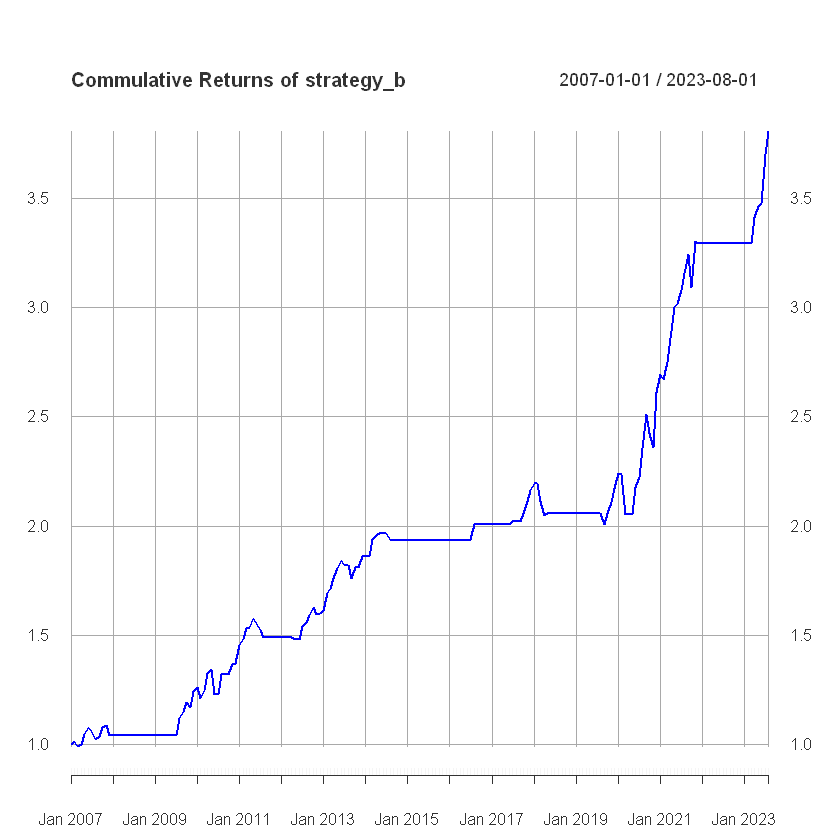

[1] -0.1866625

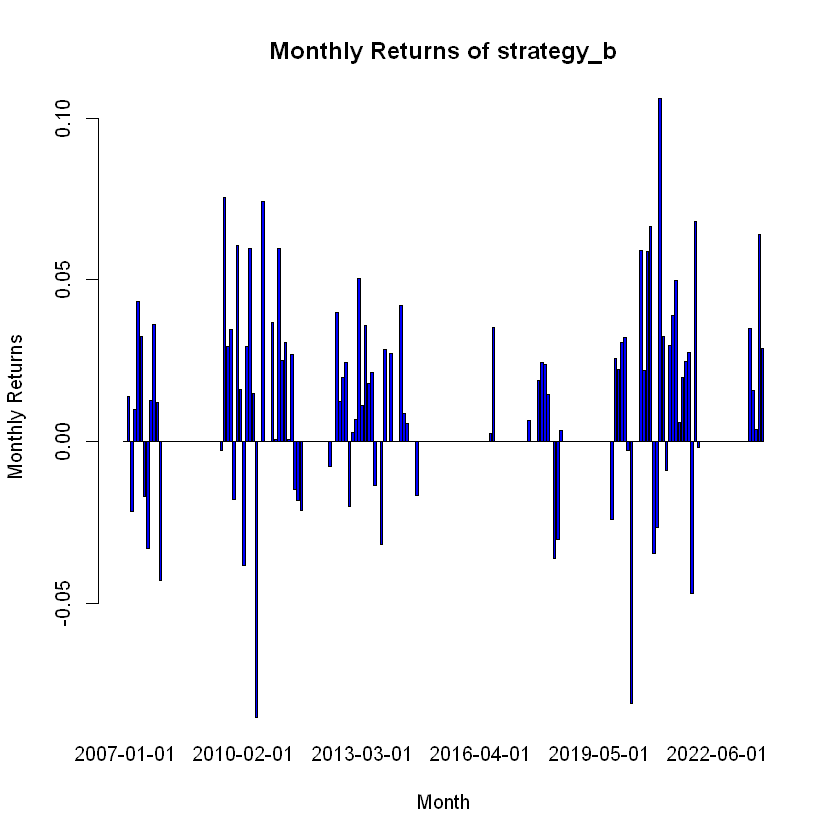

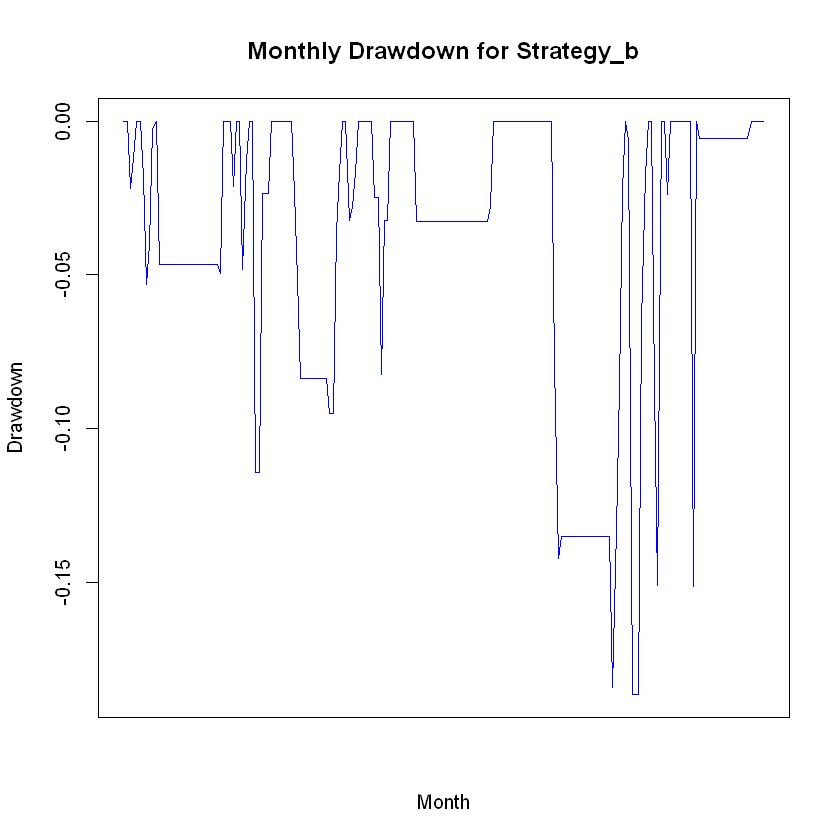

In [22]:
# plotting the commulative returns, monthly returns and drawdowns for strategy_b

strategy_returns_b[is.na(strategy_returns_b)] <- 0    #replacing initial NA by 0 to avoid plotting errors
#1.commulative returns
cumulative_returns_bb <- cumprod(1 + strategy_returns_b)
plot(cumulative_returns_bb, type = "l", col = "blue", xlab = "Date", ylab = "Value", main = "Commulative Returns of strategy_b")

#2.monthly returns
barplot(strategy_returns_b, col = "blue", 
        xlab = "Month", ylab = "Monthly Returns", 
        main = "Monthly Returns of strategy_b")

#3. Calculating maximum cumulative returns up to each month
max_cumulative_returns_bb <- cummax(cumulative_returns_bb)

# Calculating drawdown as the difference between cumulative returns and max cumulative returns
drawdown_bb <- cumulative_returns_bb - max_cumulative_returns_bb
max_drawdown_bb <- min(drawdown_bb)
max_drawdown_bb

# Creating a sequence of months for plotting
months <- seq(from = 1, to = length(drawdown_bb), by = 1)

# Plotting the drawdown for strategy_b
plot(months, drawdown_bb, type = "l", col = "blue",
     xlab = "Month", ylab = "Drawdown",
     main = "Monthly Drawdown for Strategy_b", xaxt = "n")

Strategy_c : will check the difference between moving avg of 3m and 12m in the current month, if it is positive then we will invest in the next month and vice-versa

In [23]:
#making s&p 500 dataframe which has monthly values from 2006-02-01 to 2023-08-01 , will use this to calculate moving
#average and monthly returns
sp_500_c <- read.csv('C:/Users/hrith/OneDrive/Documents/RESUME_PROJECTS_COPY/SSGA_internship_assignment/Assignment_1/s&p_500_c.csv')

# Converting the column to a time series
open_price_ts <- as.ts(sp_500_c$Open)

# Calculating the 12 and 3 month moving average
ma_12m <- rollapply(open_price_ts, width = 12, FUN = mean, align = "right", fill = NA)
ma_3m <- rollapply(open_price_ts, width = 3, FUN = mean, align = "right", fill = NA)

# Adding the calculated moving average to the dataframe
sp_500_c$ma_3m <- ma_3m
sp_500_c$ma_12m <- ma_12m

#Making the indicator
sp_500_c$ma_3_diff_ma_12m <- sp_500_c$ma_3m - sp_500_c$ma_12m
sp_500_c$indicator_p <- c(rep(NA, 1), head(sp_500_c$ma_3_diff_ma_12m, -1))  #shifting indicator with the same reason as that shifting the months

cat(" initial rows of sp_500_c :", "\n")
head(sp_500_c)

 initial rows of sp_500_c : 


Date,Open,High,Low,Close,Adj.Close,Volume,ma_3m,ma_12m,ma_3_diff_ma_12m,indicator_p
2006-02-01,1280.08,1297.57,1253.61,1280.66,1280.66,42859940000,NA,NA,NA,NA
2006-03-01,1280.66,1310.88,1268.42,1294.87,1294.87,50905040000,NA,NA,NA,NA
2006-04-01,1302.88,1318.16,1280.74,1310.61,1310.61,43308430000,1287.873,NA,NA,NA
2006-05-01,1310.61,1326.70,1245.34,1270.09,1270.09,54312830000,1298.050,NA,NA,NA
2006-06-01,1270.05,1290.68,1219.29,1270.20,1270.20,54873260000,1294.513,NA,NA,NA
2006-07-01,1270.06,1280.42,1224.54,1276.66,1276.66,46348220000,1283.573,NA,NA,NA


In [24]:
# making the binary vector as investment strategy based on strategy_c
investment_strategy_c <- ifelse(sp_500_c$indicator_p > 0, 1, 0)

cat("monthly investment decisions of strategy_c :", "\n")
print(investment_strategy_c)

monthly investment decisions of strategy_c : 
  [1] NA NA NA NA NA NA NA NA NA NA NA NA  1  1  1  1  1  1  1  1  1  1  1  1  1
 [26]  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1
 [51]  1  1  1  1  1  0  0  0  1  1  1  1  1  1  1  1  1  1  1  0  0  0  0  0  1
 [76]  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
[101]  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  0  0  0  0  1  0  0  0  0
[126]  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
[151]  1  1  1  1  1  1  0  0  0  1  1  1  1  1  1  1  1  1  1  1  1  0  0  0  1
[176]  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  0  0  0  0
[201]  0  0  0  0  0  0  0  1  1  1  1


In [25]:
# calculating the monthly returns for strategy_c
strategy_returns_c <- investment_strategy_c * c(0, diff(sp_500_c$Open)) / lag(sp_500_c$Open)

sp_500_c$Date <- as.Date(sp_500_c$Date)
strategy_returns_c <- xts(strategy_returns_c, order.by = sp_500_c$Date)

cat("monthly returs of strategy_c :", "\n")
strategy_returns_c

monthly returs of strategy_c : 


                    [,1]
2006-02-01            NA
2006-03-01            NA
2006-04-01            NA
2006-05-01            NA
2006-06-01            NA
2006-07-01            NA
2006-08-01            NA
2006-09-01            NA
2006-10-01            NA
2006-11-01            NA
2006-12-01            NA
2007-01-01            NA
2007-02-01  0.0140123937
2007-03-01 -0.0216287468
2007-04-01  0.0099729220
2007-05-01  0.0433127404
2007-06-01  0.0325492287
2007-07-01 -0.0169604219
2007-08-01 -0.0328844917
2007-09-01  0.0129055557
2007-10-01  0.0361814971
2007-11-01  0.0121129579
2007-12-01 -0.0428001427
2008-01-01 -0.0078803715
2008-02-01 -0.0608799886
2008-03-01  0.0000000000
2008-04-01  0.0000000000
2008-05-01  0.0000000000
2008-06-01  0.0000000000
2008-07-01  0.0000000000
2008-08-01  0.0000000000
2008-09-01  0.0000000000
2008-10-01  0.0000000000
2008-11-01  0.0000000000
2008-12-01  0.0000000000
2009-01-01  0.0000000000
2009-02-01  0.0000000000
2009-03-01  0.0000000000
2009-04-01  0.0000000000


In [26]:
#calculating the performance measures:

performance_params_c <- calculate_performance_parameters(strategy_returns_c, risk_free_rate)

# Print the results
cat("performance parameters of strategy_c :", "\n")
print(performance_params_c)

performance parameters of strategy_c : 
$Max_Drawdown
[1] 0.5121146

$Cumulative_Return
[1] 218.9599

$Annualized_Return
[1] 4.839394

$Annualized_Risk
[1] 0.1178937

$Sharpe_Ratio
[1] 0.410488



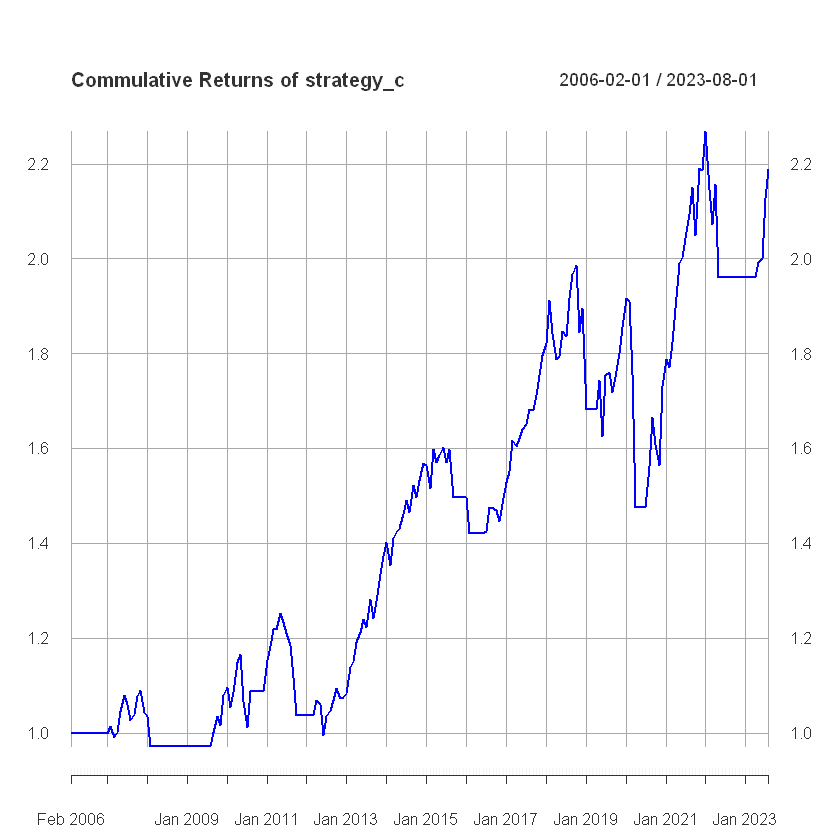

[1] -0.5121146

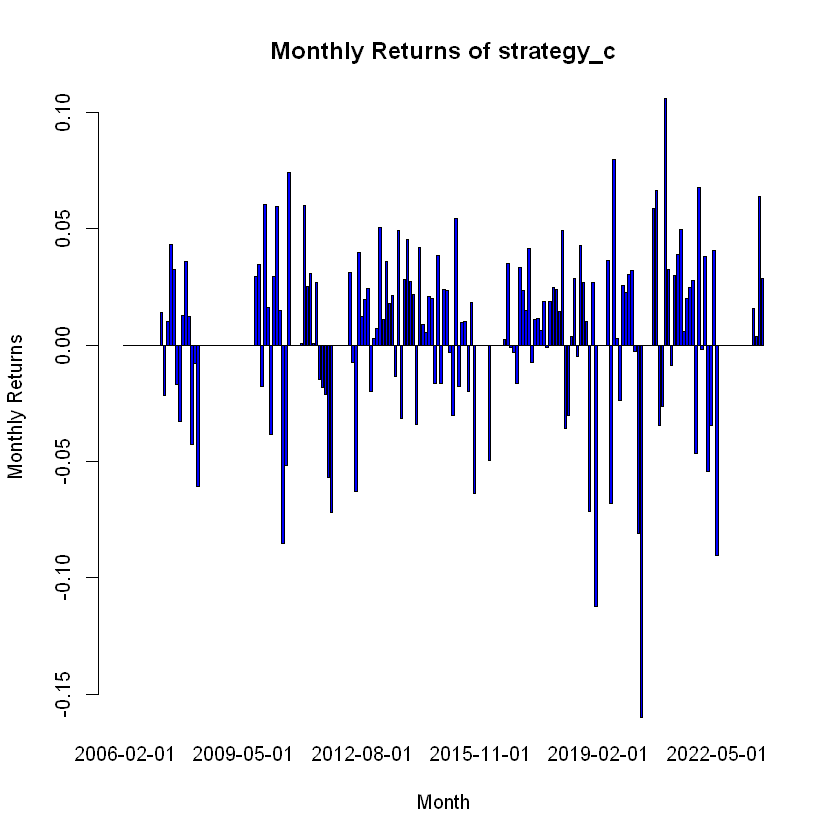

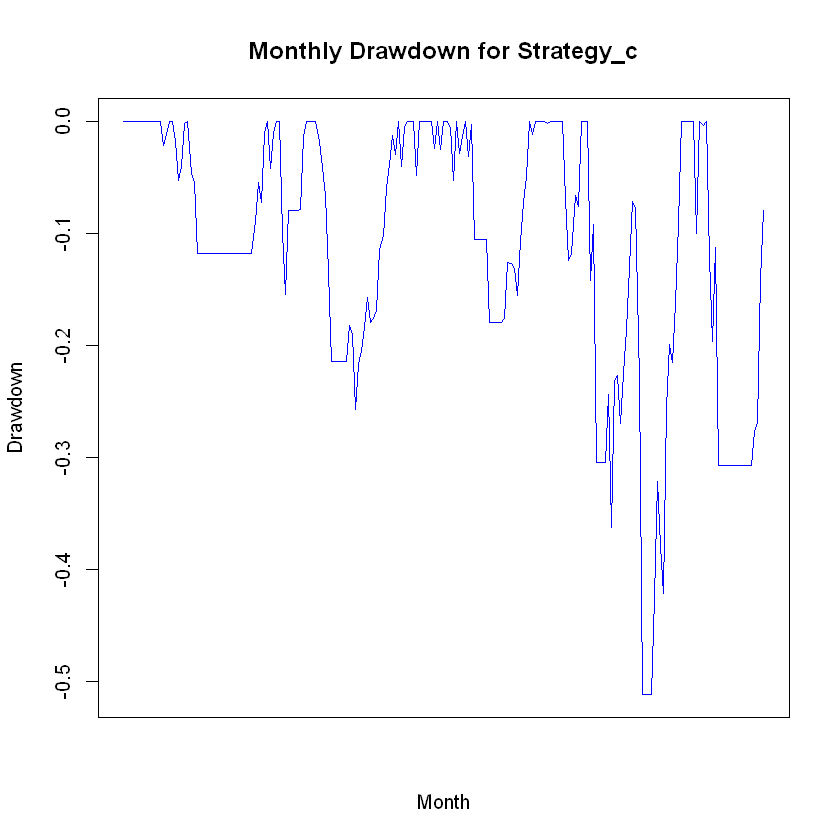

In [27]:
# plotting the commulative returns, monthly returns and drawdowns for strategy_c
strategy_returns_c[is.na(strategy_returns_c)] <- 0    #replacing initial NA by 0 to avoid plotting errors
#1.commulative returns
cumulative_returns_cc <- cumprod(1 + strategy_returns_c)
plot(cumulative_returns_cc, type = "l", col = "blue", xlab = "Date", ylab = "Value", main = "Commulative Returns of strategy_c")

#2.monthly returns
barplot(strategy_returns_c, col = "blue", 
        xlab = "Month", ylab = "Monthly Returns", 
        main = "Monthly Returns of strategy_c")

#3. Calculating maximum cumulative returns up to each month
max_cumulative_returns_cc <- cummax(cumulative_returns_cc)

# Calculating drawdown as the difference between cumulative returns and max cumulative returns
drawdown_cc <- cumulative_returns_cc - max_cumulative_returns_cc
max_drawdown_cc <- min(drawdown_cc)
max_drawdown_cc

# Creating a sequence of months for plotting
months <- seq(from = 1, to = length(drawdown_cc), by = 1)

# Plotting the drawdown for strategy_c
plot(months, drawdown_cc, type = "l", col = "blue",
     xlab = "Month", ylab = "Drawdown",
     main = "Monthly Drawdown for Strategy_c", xaxt = "n")

strategy d : remain invested throughout (benchmark)

In [28]:
# here the strategy will be represented by 1 vector 
investment_strategy_d <- rep(1, length(investment_strategy_a))

cat("monthly investment decisions of strategy_d :", "\n")
print(investment_strategy_d)

monthly investment decisions of strategy_d : 
  [1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [38] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [75] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[112] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[149] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[186] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


In [29]:
#using sp_500_a for this strategy
sp_500_d <- sp_500_a

#calculating monthly returns for strategy_d
strategy_returns_d <- investment_strategy_d * c(0, diff(sp_500_d$Open)) / lag(sp_500_d$Open)

strategy_returns_d <- xts(strategy_returns_d, order.by = sp_500_d$Date)

cat("monthly returs of strategy_d :", "\n")
strategy_returns_d

monthly returs of strategy_d : 


                    [,1]
2007-01-01            NA
2007-02-01  1.401239e-02
2007-03-01 -2.162875e-02
2007-04-01  9.972922e-03
2007-05-01  4.331274e-02
2007-06-01  3.254923e-02
2007-07-01 -1.696042e-02
2007-08-01 -3.288449e-02
2007-09-01  1.290556e-02
2007-10-01  3.618150e-02
2007-11-01  1.211296e-02
2007-12-01 -4.280014e-02
2008-01-01 -7.880372e-03
2008-02-01 -6.087999e-02
2008-03-01 -3.492676e-02
2008-04-01 -3.036504e-03
2008-05-01  4.490311e-02
2008-06-01  9.848716e-03
2008-07-01 -8.783102e-02
2008-08-01 -5.694333e-03
2008-09-01  1.450262e-02
2008-10-01 -9.602193e-02
2008-11-01 -1.679308e-01
2008-12-01 -8.264940e-02
2009-01-01  1.618258e-02
2009-02-01 -8.848378e-02
2009-03-01 -1.136206e-01
2009-04-01  8.775034e-02
2009-05-01  9.973659e-02
2009-06-01  5.788668e-02
2009-07-01 -2.642812e-03
2009-08-01  7.536757e-02
2009-09-01  2.958943e-02
2009-10-01  3.471243e-02
2009-11-01 -1.775505e-02
2009-12-01  6.052033e-02
2010-01-01  1.607990e-02
2010-02-01 -3.821563e-02
2010-03-01  2.930465e-02


In [30]:
# performance measures
strategy_returns_d[is.na(strategy_returns_d)] <- 0    #replacing initial NA by 0
performance_params_d <- calculate_performance_parameters(strategy_returns_d,risk_free_rate)

# Printing the results
cat("performance parameters of strategy_d :", "\n")
print(performance_params_d)

performance parameters of strategy_d : 
$Max_Drawdown
[1] 0.8239319

$Cumulative_Return
[1] 322.9008

$Annualized_Return
[1] 7.28627

$Annualized_Risk
[1] 0.1634882

$Sharpe_Ratio
[1] 0.4456757



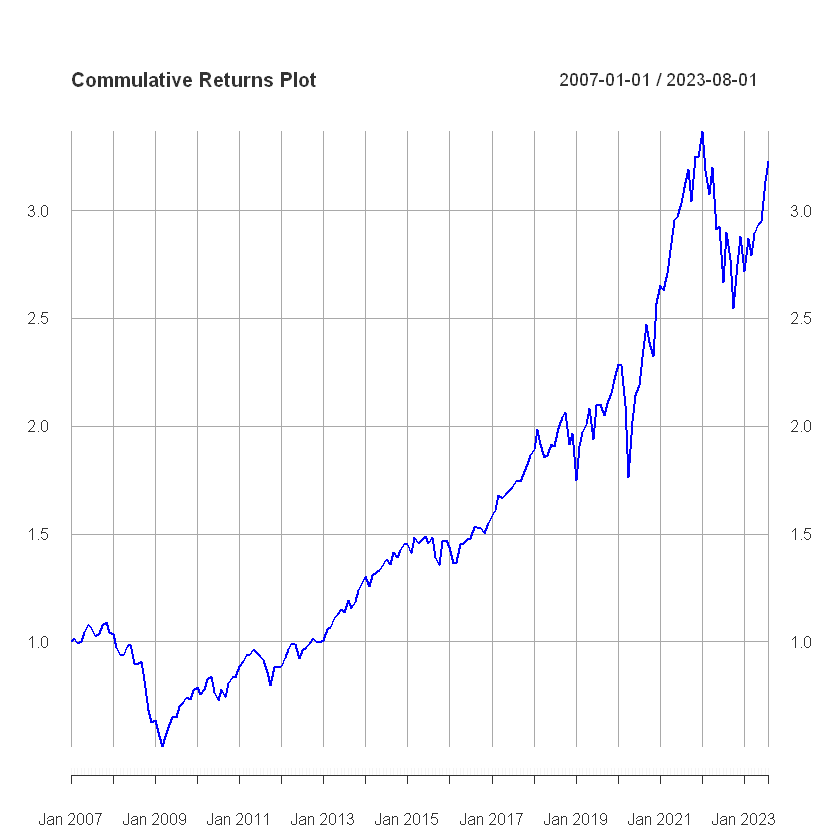

[1] -0.8239319

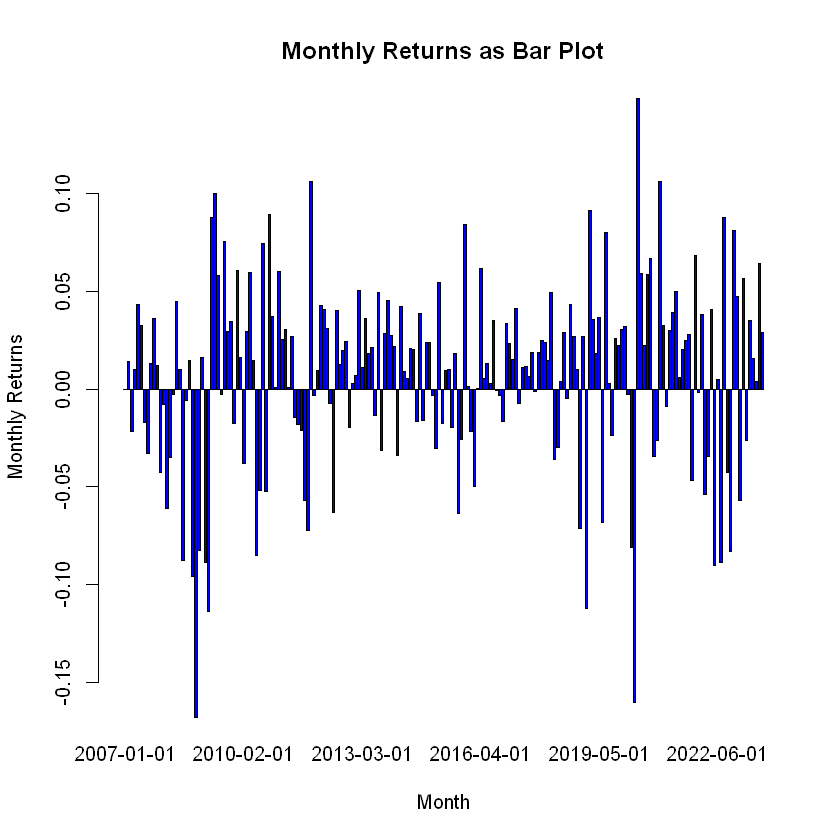

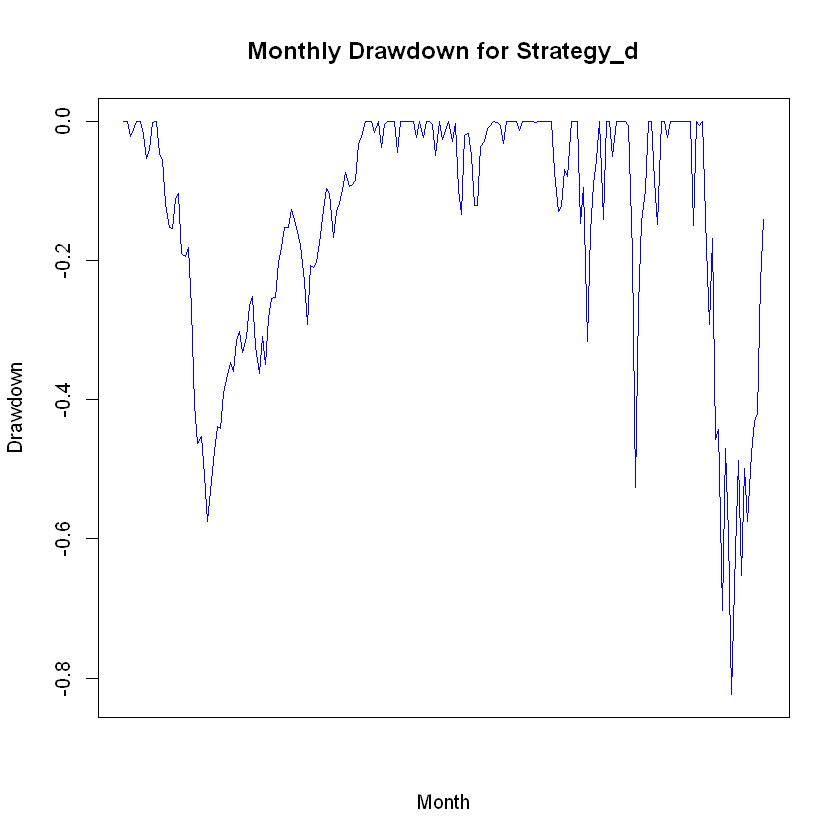

In [31]:
# plotting the commulative returns, monthly returns and drawdowns for strategy_d

#1.commulative returns
cumulative_returns_dd <- cumprod(1 + strategy_returns_d)
plot(cumulative_returns_dd, type = "l", col = "blue", xlab = "Date", ylab = "Value", main = "Commulative Returns Plot")

#2.monthly returns
barplot(strategy_returns_d, col = "blue", 
        xlab = "Month", ylab = "Monthly Returns", 
        main = "Monthly Returns as Bar Plot")

#3. Calculating maximum cumulative returns up to each month
max_cumulative_returns_dd <- cummax(cumulative_returns_dd)

# Calculating drawdown as the difference between cumulative returns and max cumulative returns
drawdown_dd <- cumulative_returns_dd - max_cumulative_returns_dd
max_drawdown_dd <- min(drawdown_dd)
max_drawdown_dd

# Creating a sequence of months for plotting
months <- seq(from = 1, to = length(drawdown_dd), by = 1)

# Plotting the drawdown for strategy_d
plot(months, drawdown_dd, type = "l", col = "blue",
     xlab = "Month", ylab = "Drawdown",
     main = "Monthly Drawdown for Strategy_d", xaxt = "n")

Strategy_e : Here we will try to implement the econoic trend paper where they assigned equal weights to changes in S&P500
and credit spreads for the risk aversion indicator. 

We will incorporate this as follows:
will give wt=1 if any column except (3m-12m moving_avg of credit spread) and (3m-12m moving_avg ofS&P500) is positive for current month. Will 0.5 weight to these two columns if they are +ve for current month.

Investment strategy will be same as that of strategy_b , we will use the same indicators as that of strategy_b and one extra indicator of (3m-12m moving_avg ofS&P500). and here also the threshold will be >=3 (for now)

In [32]:
indicator_p <- na.omit(sp_500_c$indicator_p)   #this column was made in strategy_c and it is what we want for strategy_e
Indicators_data_selected_e <- cbind(Indicators_data_selected_b, indicator_p)   #creating the indicator data for strategy_e

cat(" initial rows of selected indicators for this strategy :", "\n")
head(Indicators_data_selected_e)

 initial rows of selected indicators for this strategy : 


date,indicator_1,indicator_2b,indicator_3b,indicator_4b,indicator_5b,indicator_p
2007-02-01,-0.48,0.9469720,1.0508500,-0.3912500,0.2259669,79.73083
2007-03-01,0.19,1.1716580,0.8352500,-0.3216667,0.3395919,86.62583
2007-04-01,0.23,1.0236103,0.4783250,-0.2533333,0.3514924,78.17085
2007-05-01,-0.11,0.7938081,0.8695833,-0.1891667,0.3336249,69.27499
2007-06-01,0.03,0.6636358,1.5551083,-0.1470833,0.3140452,69.78498
2007-07-01,-0.05,0.6418270,2.0567583,-0.1429167,0.3407876,89.34414


In [33]:
# Define the minimum number of positive indicators required to invest
min_positive_indicators <- 3

# Creating a weight vector for the columns I want to assign a weight of 0.5 (order should be same)
weight_vector <- c(1, 1, 1, 1, 0.5, 0.5) 

# Calculating a binary vector for monthly investment decisions with weighted columns
investment_strategy_e <- Indicators_data_selected_e %>%
  mutate(positive_indicators = rowSums(select(., starts_with("indicator")) > 0)) %>%
  mutate(invest = ifelse(positive_indicators >= min_positive_indicators, 1, 0)) %>%
  pull(invest)

# Inserting 0 in the front, so that length is same as the return vector and it means that we are not investing in 2007/01/01
investment_strategy_e <- c(0, investment_strategy_e)

# Printing the binary vector
cat("monthly investment decisions of this strategy :", "\n")
print(investment_strategy_e)

monthly investment decisions of this strategy : 
  [1] 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 [38] 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 [75] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0
[112] 0 0 0 1 1 1 0 0 0 1 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
[149] 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0
[186] 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1


In [34]:
#using the same sp_500_a dataframe to calculate the monthly return
sp_500_e<- sp_500_a

In [35]:
# calculating monthly returns of strategy_e
strategy_returns_e <- investment_strategy_e * c(0, diff(sp_500_e$Open)) / lag(sp_500_e$Open)

# Converting the date column to a Date format
sp_500_e$Date <- as.Date(sp_500_e$Date)

# Creating an xts time series object
strategy_returns_e <- xts(strategy_returns_e, order.by = sp_500_e$Date)

cat("monthly returs of this strategy :", "\n")
strategy_returns_e

monthly returs of this strategy : 


                    [,1]
2007-01-01            NA
2007-02-01  0.0140123937
2007-03-01 -0.0216287468
2007-04-01  0.0099729220
2007-05-01  0.0433127404
2007-06-01  0.0325492287
2007-07-01 -0.0169604219
2007-08-01 -0.0328844917
2007-09-01  0.0129055557
2007-10-01  0.0361814971
2007-11-01  0.0121129579
2007-12-01 -0.0428001427
2008-01-01 -0.0078803715
2008-02-01 -0.0608799886
2008-03-01  0.0000000000
2008-04-01  0.0000000000
2008-05-01  0.0000000000
2008-06-01  0.0000000000
2008-07-01  0.0000000000
2008-08-01  0.0000000000
2008-09-01  0.0000000000
2008-10-01  0.0000000000
2008-11-01  0.0000000000
2008-12-01  0.0000000000
2009-01-01  0.0000000000
2009-02-01  0.0000000000
2009-03-01  0.0000000000
2009-04-01  0.0000000000
2009-05-01  0.0000000000
2009-06-01  0.0000000000
2009-07-01 -0.0026428118
2009-08-01  0.0753675668
2009-09-01  0.0295894344
2009-10-01  0.0347124274
2009-11-01 -0.0177550501
2009-12-01  0.0605203321
2010-01-01  0.0160799022
2010-02-01 -0.0382156281
2010-03-01  0.0293046497


In [36]:
#  performance measures:
#calculating the performance parameters
performance_params_e <- calculate_performance_parameters(strategy_returns_e,risk_free_rate)

# Printing the results
cat("performance parameters of strategy_e :", "\n")
print(performance_params_e)

performance parameters of strategy_e : 
$Max_Drawdown
[1] 0.5031362

$Cumulative_Return
[1] 306.3768

$Annualized_Return
[1] 6.984772

$Annualized_Risk
[1] 0.1079757

$Sharpe_Ratio
[1] 0.646884



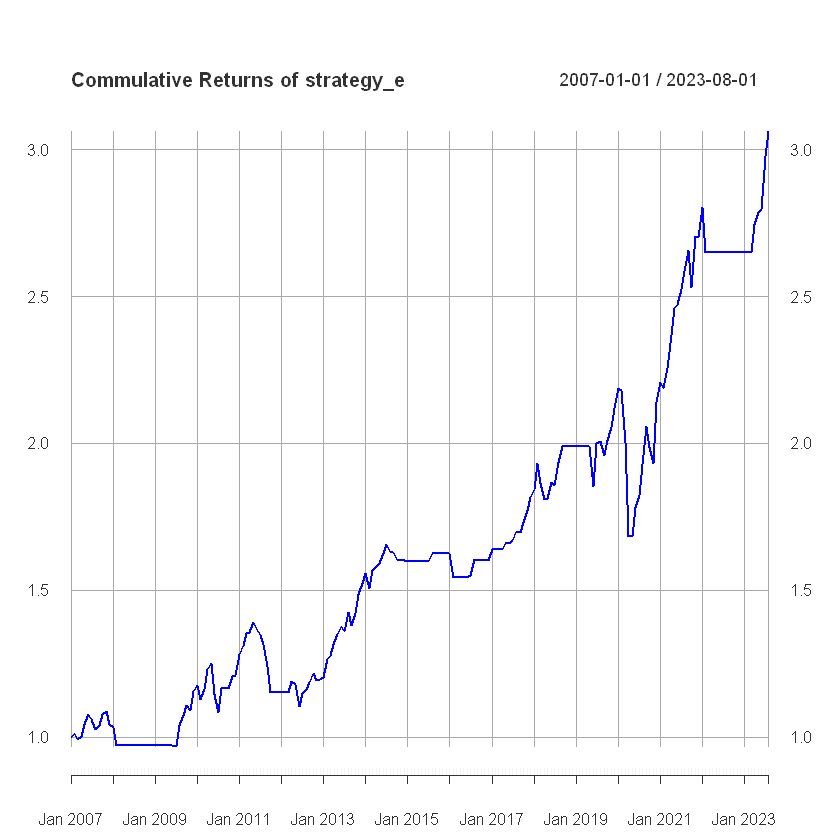

[1] -0.5031362

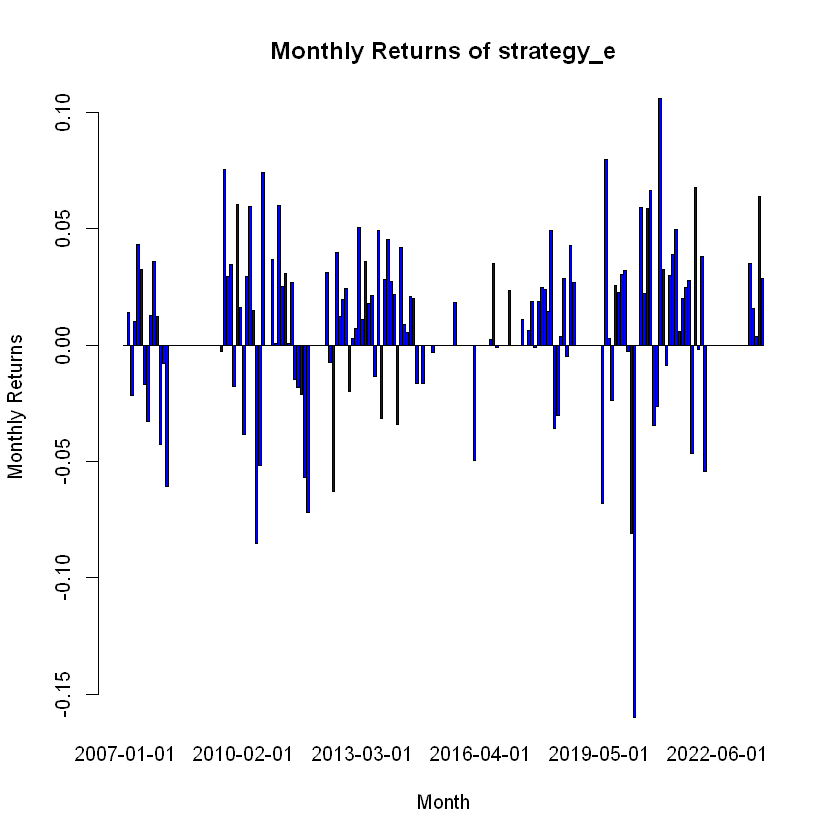

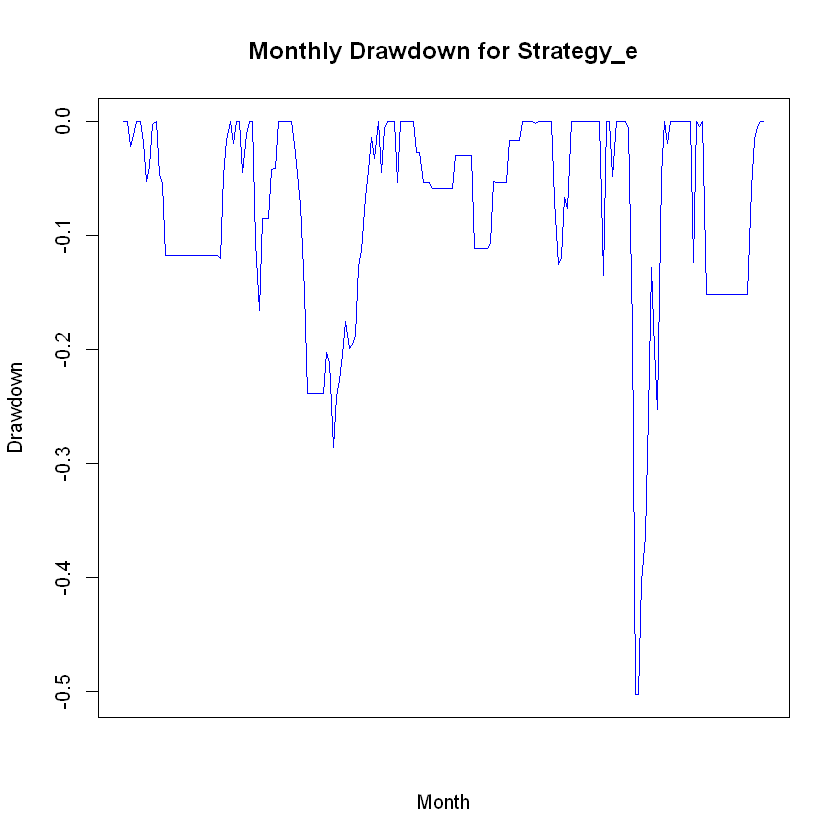

In [37]:
# plotting the commulative returns, monthly returns and drawdowns for strategy_e

strategy_returns_e[is.na(strategy_returns_e)] <- 0    #replacing initial NA by 0 to avoid plotting errors
#1.commulative returns
cumulative_returns_ee <- cumprod(1 + strategy_returns_e)
plot(cumulative_returns_ee, type = "l", col = "blue", xlab = "Date", ylab = "Value", main = "Commulative Returns of strategy_e")

#2.monthly returns
barplot(strategy_returns_e, col = "blue", 
        xlab = "Month", ylab = "Monthly Returns", 
        main = "Monthly Returns of strategy_e")

#3. Calculating maximum cumulative returns up to each month
max_cumulative_returns_ee <- cummax(cumulative_returns_ee)

# Calculating drawdown as the difference between cumulative returns and max cumulative returns
drawdown_ee <- cumulative_returns_ee - max_cumulative_returns_ee
max_drawdown_ee <- min(drawdown_ee)
max_drawdown_ee

# Creating a sequence of months for plotting
months <- seq(from = 1, to = length(drawdown_ee), by = 1)

# Plotting the drawdown for strategy_b
plot(months, drawdown_ee, type = "l", col = "blue",
     xlab = "Month", ylab = "Drawdown",
     main = "Monthly Drawdown for Strategy_e", xaxt = "n")

TABLE for comparison among different strategies:

In [38]:
strategy_comparison <- data.frame(
  Strategy_a = unlist(performance_params_a),
  Strategy_b = unlist(performance_params_b),
  Strategy_c = unlist(performance_params_c),
  Strategy_d_benchmark = unlist(performance_params_d),
  Strategy_e = unlist(performance_params_e))

In [39]:
cat("Comparison table : ", "\n")
strategy_comparison

Comparison table :  


,Strategy_a,Strategy_b,Strategy_c,Strategy_d_benchmark,Strategy_e
Max_Drawdown,0.19411058,0.18666255,0.5121146,0.8239319,0.5031362
Cumulative_Return,278.01091032,380.55862798,218.9599219,322.9007837,306.3768253
Annualized_Return,6.35982115,8.39276524,4.8393936,7.2862699,6.9847718
Annualized_Risk,0.09526185,0.08248844,0.1178937,0.1634882,0.1079757
Sharpe_Ratio,0.66761470,1.01744748,0.4104880,0.4456757,0.6468840


In [40]:
# We can see that we got the maximum sharpe ratio for strategy_b whivh was formulated in Notebook1 after visually
# analysing the trends of all 6 time series. We can see that strategy_b is best in every aspect which is quite surprising.